# DSCI-552 Final Project

Cassandra Man, USC ID #4731096972

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Reshape, Softmax, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import OneHotEncoder
from skimage.color import rgb2gray
from skimage import img_as_ubyte
import splitfolders
import cv2
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
import os
import glob
import shutil
import sys
import numpy as np
from skimage.io import imread
import matplotlib.pyplot as plt
from IPython.display import Image
from tensorflow.keras.applications import EfficientNetB0 as Net
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input
%matplotlib inline

## B. Data Exploration and Pre-processing

### ii. Randomly select images for training, validation, and test set

In [2]:
# Split into training, validation, and test set
splitfolders.ratio("../data/images", output="../data/output", seed=1337, ratio=(.7, 0.15,0.15)) 

Copying files: 1176 files [00:01, 703.85 files/s]


### iii. Resize dataset images

In [3]:
# Encode classes using one-hot encoding and Classes.xlsx
# Resize images
img_height = 150
img_width = 150
train_ds = tf.keras.preprocessing.image_dataset_from_directory("../data/output/train", image_size=(img_height, img_width), batch_size = 5, label_mode = "categorical")
test_ds = tf.keras.preprocessing.image_dataset_from_directory("../data/output/test", image_size=(img_height, img_width), batch_size = 5, label_mode = "categorical")
val_ds = tf.keras.preprocessing.image_dataset_from_directory("../data/output/val", image_size=(img_height, img_width), batch_size = 5, label_mode = "categorical")

2022-12-11 16:05:28.413278: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 820 files belonging to 20 classes.
Found 185 files belonging to 20 classes.
Found 171 files belonging to 20 classes.


In [4]:
class_names = train_ds.class_names
class_names

['005.Crested_Auklet',
 '013.Bobolink',
 '015.Lazuli_Bunting',
 '023.Brandt_Cormorant',
 '040.Olive_sided_Flycatcher',
 '041.Scissor_tailed_Flycatcher',
 '067.Anna_Hummingbird',
 '072.Pomarine_Jaeger',
 '076.Dark_eyed_Junco',
 '081.Pied_Kingfisher',
 '082.Ringed_Kingfisher',
 '086.Pacific_Loon',
 '099.Ovenbird',
 '104.American_Pipit',
 '127.Savannah_Sparrow',
 '135.Bank_Swallow',
 '141.Artic_Tern',
 '149.Brown_Thrasher',
 '156.White_eyed_Vireo',
 '168.Kentucky_Warbler']

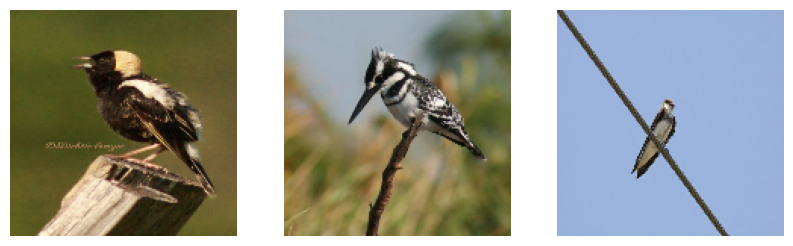

In [5]:
# Plot image 
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

## C. Transfer Learning

## EfficientNetB0 Model

### i. Use pre-trained models EfficientNetB0, only training the last fully connected layer, and will freeze all layers before them

In [6]:
# Set parameters 
batch_size = 5
width = 100
height = 100
epochs = 50
dropout_rate = 0.2
input_shape = (height, width, 3)

In [7]:
# Load pre-trained EfficientNetB0 model
conv_base = Net(weights='imagenet', include_top=False, input_shape=input_shape)

### ii. Perform empirical regularization via crop, random zoom, rotate, flip, contrast, translate images in training set

In [8]:
# Augment training set images
data_augmentation = keras.Sequential(
    [layers.RandomCrop(100, 100), 
     layers.RandomZoom(.1),
     layers.RandomRotation(.1),
     layers.RandomFlip(mode="horizontal"),
     layers.RandomContrast(.1),
     layers.RandomTranslation(.3, .3)
    ])

In [9]:
aug_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

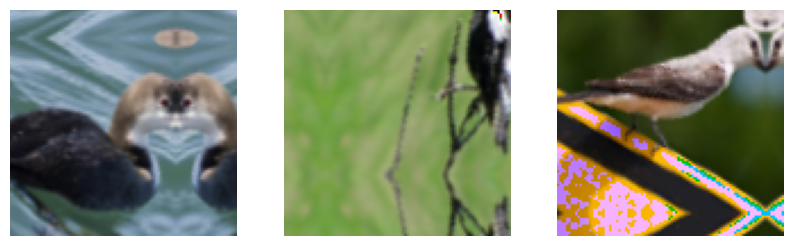

In [10]:
# Plot augmented image 
plt.figure(figsize=(10, 10))
for images, labels in aug_train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [11]:
# Resize test and validation datasets
def preprocess_dataset(image, label):
    image = tf.image.resize(image, (100, 100))
    return (image, label)

In [12]:
val_ds_map = val_ds.map(preprocess_dataset)
test_ds_map = test_ds.map(preprocess_dataset)

### iii. Build model with: ReLU activation functions, softmax layer, batch normalization, dropout rate of 20%, ADAM optimizer, multinomial cross entropy loss, batch size of 5 

In [13]:
# Build model
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu', name="fc1"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(20, activation='softmax', name="fc_out"))

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 4, 4, 1280)        4049571   
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
fc1 (Dense)                  (None, 256)               327936    
_________________________________________________________________
dropout_out (Dropout)        (None, 256)               0         
_________________________________________________________________
fc_out (Dense)               (None, 20)                5140      
Total params: 4,387,767
Trainable params: 4,343,184
Non-trainable params: 44,583
_______________________________________

In [15]:
conv_base.trainable = False

### iv. Train network and plot training and validation errors vs. epochs.

In [16]:
# Set up early stopping to keep params that have lowest validation error
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [17]:
# Set up metrics for model
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [18]:
# Compile model and fit to augmented data
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy', recall, precision, f1_score])
history = model.fit(aug_train_ds, epochs = epochs, batch_size = batch_size, validation_data = val_ds_map, callbacks=[early_stopping_monitor])

Epoch 1/50
164/164 [==============================] - 21s 90ms/step - loss: 7.4473 - accuracy: 0.2195 - recall: 0.0372 - precision: 0.9756 - f1_score: 0.0713 - val_loss: 4.8846 - val_accuracy: 0.4152 - val_recall: 0.0411 - val_precision: 1.0000 - val_f1_score: 0.0789
Epoch 2/50
164/164 [==============================] - 12s 75ms/step - loss: 2.6076 - accuracy: 0.2659 - recall: 0.0142 - precision: 0.8720 - f1_score: 0.0279 - val_loss: 2.9459 - val_accuracy: 0.4561 - val_recall: 0.0354 - val_precision: 1.0000 - val_f1_score: 0.0682
Epoch 3/50
164/164 [==============================] - 12s 75ms/step - loss: 2.6064 - accuracy: 0.2671 - recall: 0.0154 - precision: 0.8659 - f1_score: 0.0301 - val_loss: 3.3280 - val_accuracy: 0.4386 - val_recall: 0.0377 - val_precision: 1.0000 - val_f1_score: 0.0725
Epoch 4/50
164/164 [==============================] - 12s 71ms/step - loss: 2.6329 - accuracy: 0.2671 - recall: 0.0134 - precision: 0.7988 - f1_score: 0.0262 - val_loss: 2.4956 - val_accuracy: 0.4

In [19]:
def plot_hist(hist):
    acc_list = hist.history["accuracy"]
    err_list = []
    for i in acc_list:
        err_list.append(1-i)

    val_acc_list = hist.history["val_accuracy"]
    val_err_list = []
    for i in val_acc_list:
        val_err_list.append(1-i)
    
    plt.plot(err_list)
    plt.plot(val_err_list)
    plt.title("model accuracy")
    plt.ylabel("error")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

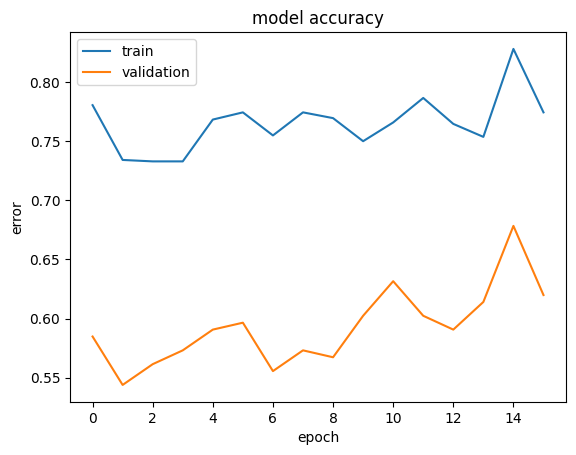

In [20]:
plot_hist(history)

### v. Report Precision, Recall, and F1 score 

In [21]:
# Make prediction on test data and report metrics
predictions = model.predict(test_ds_map)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_ds_map, verbose=0)

In [22]:
print("Weighted average EfficientNetB0 Precision: " + str(precision))
print("Weighted average EfficientNetB0 Recall: " + str(recall))
print("Weighted average EfficientNetB0 F1-Score: " + str(f1_score))

Weighted average EfficientNetB0 Precision: 1.0
Weighted average EfficientNetB0 Recall: 0.05503673851490021
Weighted average EfficientNetB0 F1-Score: 0.02837837114930153


## VGG16 Model

### i. Use pre-trained models VGG16, only training the last fully connected layer, and will freeze all layers before them

In [23]:
# Set parameters 
batch_size = 5
width = 100
height = 100
epochs = 50
dropout_rate = 0.2
input_shape = (height, width, 3)

In [24]:
# Load pre-trained EfficientNetB0 model
conv_base = VGG16(include_top=False,
                     weights='imagenet', 
                     input_shape=input_shape)

### ii. Perform empirical regularization via crop, random zoom, rotate, flip, contrast, translate images in training set

In [25]:
# Augment training set images
data_augmentation = keras.Sequential(
    [layers.RandomCrop(100, 100), 
     layers.RandomZoom(.1),
     layers.RandomRotation(.1),
     layers.RandomFlip(mode="horizontal"),
     layers.RandomContrast(.1),
     layers.RandomTranslation(.3, .3)
    ])

In [26]:
aug_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

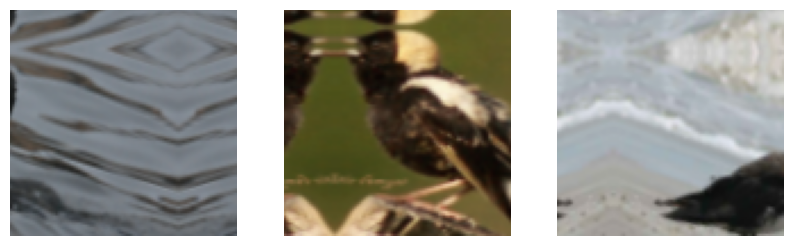

In [27]:
# Plot augmented image 
plt.figure(figsize=(10, 10))
for images, labels in aug_train_ds.take(1):
    for i in range(3):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
# Resize test and validation datasets
def preprocess_dataset(image, label):
    image = tf.image.resize(image, (100, 100))
    return (image, label)

In [29]:
val_ds_map = val_ds.map(preprocess_dataset)
test_ds_map = test_ds.map(preprocess_dataset)

In [30]:
# Apply VGG16 Preprocessing
def vgg_preprocess(image, label):
    image = preprocess_input(image)
    return (image, label)

In [31]:
aug_train_ds_prep = aug_train_ds.map(vgg_preprocess)
val_ds_prep = val_ds_map.map(vgg_preprocess)
test_ds_prep = test_ds_map.map(vgg_preprocess)

### iii. Build model with: ReLU activation functions, softmax layer, batch normalization, dropout rate of 20%, ADAM optimizer, multinomial cross entropy loss, batch size of 5 

In [32]:
# Build model
model = models.Sequential()
model.add(conv_base)
model.add(layers.GlobalMaxPooling2D(name="gap"))
model.add(layers.BatchNormalization())
model.add(layers.Dense(256, activation='relu', name="fc1"))
if dropout_rate > 0:
    model.add(layers.Dropout(dropout_rate, name="dropout_out"))
model.add(layers.Dense(20, activation='softmax', name="fc_out"))

In [33]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 3, 3, 512)         14714688  
_________________________________________________________________
gap (GlobalMaxPooling2D)     (None, 512)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
fc1 (Dense)                  (None, 256)               131328    
_________________________________________________________________
dropout_out (Dropout)        (None, 256)               0         
_________________________________________________________________
fc_out (Dense)               (None, 20)                5140      
Total params: 14,853,204
Trainable params: 14,852,180
Non-trainable params: 1,024
______________________________________

In [34]:
conv_base.trainable = False

### iv. Train network and plot training and validation errors vs. epochs.

In [35]:
# Set up early stopping to keep params that have lowest validation error
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=10,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=True
)

In [36]:
# Set up metrics for model
def recall(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    all_positives = K.sum(K.round(K.clip(y_true, 0, 1)))

    recall = true_positives / (all_positives + K.epsilon())
    return recall

def precision(y_true, y_pred):
    y_true = K.ones_like(y_true)
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))

    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision_m = precision(y_true, y_pred)
    recall_m = recall(y_true, y_pred)
    return 2*((precision_m*recall_m)/(precision_m+recall_m+K.epsilon()))

In [37]:
# Compile model and fit to augmented data
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=1e-2),
              metrics=['accuracy', recall, precision, f1_score])
history = model.fit(aug_train_ds_prep, epochs = epochs, batch_size = batch_size, validation_data = val_ds_prep, callbacks=[early_stopping_monitor])

Epoch 1/50
164/164 [==============================] - 28s 165ms/step - loss: 4.0198 - accuracy: 0.2537 - recall: 0.0309 - precision: 0.9756 - f1_score: 0.0597 - val_loss: 4.2976 - val_accuracy: 0.3392 - val_recall: 0.0374 - val_precision: 1.0000 - val_f1_score: 0.0720
Epoch 2/50
164/164 [==============================] - 28s 169ms/step - loss: 2.4765 - accuracy: 0.2988 - recall: 0.0188 - precision: 0.9146 - f1_score: 0.0368 - val_loss: 3.5731 - val_accuracy: 0.3333 - val_recall: 0.0323 - val_precision: 0.9714 - val_f1_score: 0.0623
Epoch 3/50
164/164 [==============================] - 27s 163ms/step - loss: 2.3639 - accuracy: 0.3476 - recall: 0.0217 - precision: 0.9451 - f1_score: 0.0423 - val_loss: 3.1265 - val_accuracy: 0.3860 - val_recall: 0.0340 - val_precision: 0.9714 - val_f1_score: 0.0655
Epoch 4/50
164/164 [==============================] - 28s 167ms/step - loss: 2.3535 - accuracy: 0.3415 - recall: 0.0193 - precision: 0.9573 - f1_score: 0.0377 - val_loss: 3.0629 - val_accuracy:

In [38]:
def plot_hist(hist):
    acc_list = hist.history["accuracy"]
    err_list = []
    for i in acc_list:
        err_list.append(1-i)

    val_acc_list = hist.history["val_accuracy"]
    val_err_list = []
    for i in val_acc_list:
        val_err_list.append(1-i)
    
    plt.plot(err_list)
    plt.plot(val_err_list)
    plt.title("model accuracy")
    plt.ylabel("error")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

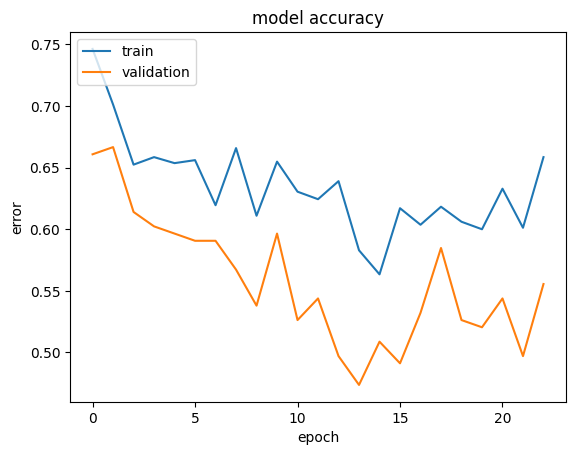

In [39]:
plot_hist(history)

### v. Report Precision, Recall, and F1 score 

In [40]:
# Make prediction on test data and report metrics
predictions = model.predict(test_ds_prep)
loss, accuracy, f1_score, precision, recall = model.evaluate(test_ds_prep, verbose=0)

In [41]:
print("Weighted average VGG16 Precision: " + str(precision))
print("Weighted average VGG16 Recall: " + str(recall))
print("Weighted average VGG16 F1-Score: " + str(f1_score))

Weighted average VGG16 Precision: 0.9729729890823364
Weighted average VGG16 Recall: 0.063080795109272
Weighted average VGG16 F1-Score: 0.032702695578336716


## Sources Referenced

Precision, recall, f1-score metrics:
https://neptune.ai/blog/keras-metrics